In [1]:
import dill
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import re
sns.set()

In [3]:
import spacy
nlp = spacy.load("en")

In [4]:
pickle_path = './Pickled/ml_ready.pkl'
ml_ready = pd.read_pickle(pickle_path)

## Setup

In [5]:
ml_ready.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition', 'Description',
       'Current Status', 'Current Status Date', 'Filed Date', 'Issued Date',
       'Completed Date', 'Number of Existing Stories',
       'Number of Proposed Stories', 'Permit Expiration Date',
       'Estimated Cost', 'Revised Cost', 'Existing Use', 'Existing Units',
       'Proposed Use', 'Proposed Units', 'Plansets',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID', 'SF Find Neighborhoods',
       'Current Police Districts', 'Current Supervisor Districts',
       'Analysis Neighborhoods', 'approval_in_days', 'Address', 'SingleLine',
       'Year', 'assess_id', 'Volume Number', 'Use Code', 'Use Definition',
       'Property Class Code', 'Property Class Code Definition',
       'Number of 

In [6]:
# 'feature engineering' aka removing extraneous numbers
ml_ready['Description'] = ml_ready['Description'].astype('str').apply(lambda x: re.sub(r'\d+','',x))

In [7]:
ml_ready['Description'] = ml_ready['Description'].astype('str')

In [8]:
ml_ready.groupby('Permit Type').size()

Permit Type
3      7683
4        40
6       125
8    116654
dtype: int64

In [9]:
ml_ready['bin_class'] = ml_ready['Permit Type'].apply(lambda x: 0 if x == 8 else 1)

In [10]:
ml_ready['bin_class'].value_counts()

0    116654
1      7848
Name: bin_class, dtype: int64

In [11]:
groups = ml_ready.groupby(['Permit Type','Permit Type Definition'])
desc_by_ptype = {}
ptypes = []

In [12]:

for name, group in groups:
    desc_by_ptype[name] = group['Description'].values
    ptypes.append(name)

In [13]:
desc_by_ptype[ptypes[0]][0]

'comply with nov  permit for furnace/water heater. legalize(e)unit (unit b) on grd floor with  bedroom,  full bath, kitchen & living room per plan. add deck at rear of building for unit a access to rear yard (open common space) per plan. unit legalization ord -.'

In [14]:
ptypes

[(3, 'additions alterations or repairs'),
 (4, 'sign - erect'),
 (6, 'demolitions'),
 (8, 'otc alterations permit')]

In [15]:
t = td_nb.named_steps['tfidf']
response = t.fit_transform(ml_ready['Description'])


NameError: name 'td_nb' is not defined

In [16]:
feature_array = np.array(t.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

NameError: name 't' is not defined

## ISSUE - numbers in the permits indicating street, floor are quite common and polluting the features, esp as ngram_range increases


In [17]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    ml_ready['Description'].values,
    ml_ready['bin_class'],
    test_size = 0.2
)

In [18]:
# Use sklear.feature_extraction.text tfidfVectorizer to get tf-idf values
# Tfidf Vectorizer  combines of count-vectorizing AND transforming count->tfidf vals
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS # avoid and, a , on, etc?
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



In [30]:
params_grid = {
    'tfidf__max_features':[5000],
    'tfidf__ngram_range':[(1,2)],
    'tfidf__min_df':[31], #is 2 a reasonable best value here?
    'tfidf__max_df':[0.0001,0.001, 0.01, 0.1, 0.3, 0.5,],
#     'tfidf__stop_words':[STOP_WORDS.union({'ll', 've'})],
#     'rf__max_depth':[17],
#     'rf__n_estimators':[100],
#     'rf__class_weight':['balanced'],
#     'logreg__solver':['saga'], no significant difference found here
#     'logreg__penalty':['l2'] #l2 penalty shown better
    'logreg__C':[0.1]
    
    
}
td_nb = Pipeline([
    # Column selector (remember the ML project?)
#     ('ct', ColumnSelectTransformer(['text'])),
    # TFIDF Vectorizer
    ('tfidf', TfidfVectorizer(stop_words=STOP_WORDS.union({'ll', 've', 'NaN', 'nan',
                                                          'replace','remodel'}))),
    # Regressor
    ('logreg', LogisticRegression(class_weight='balanced'))
#     ('rf', RandomForestClassifier())
#     ('nb', ComplementNB())
])

# Grid search scoring question: precision, accuracy or recall?
# scorer = make_scorer(precision_score, average='weighted')
gcv = GridSearchCV(td_nb, params_grid, scoring='recall', n_jobs=4, verbose=4)

gcv.fit(Xtrain,ytrain)
gcv.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   22.7s finished


{'logreg__C': 0.1,
 'tfidf__max_df': 0.3,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 31,
 'tfidf__ngram_range': (1, 2)}

In [31]:
gcv.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.3, max_features=5000, min_df=31,
                                 ngram_range=(1, 2),
                                 stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'NaN', 'a', 'about',
                                             'above', 'across', 'after',
                                             'afterwards', 'again', 'against',
                                             'all', 'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', 'another', ...})),
                ('logreg', LogisticRegression(C=0.1, class_weight='balanced'))])

In [32]:
pd.DataFrame(gcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_tfidf__max_df,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.821344,0.036214,0.000000,0.000000,0.1,0.0001,5000,31,"(1, 2)","{'logreg__C': 0.1, 'tfidf__max_df': 0.0001, 't...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,2.276238,0.051873,0.397901,0.028432,0.1,0.001,5000,31,"(1, 2)","{'logreg__C': 0.1, 'tfidf__max_df': 0.001, 'tf...",0.628709,0.613162,0.621188,0.616680,0.647955,0.625539,0.012354,5
2,2.257142,0.115799,0.407603,0.009399,0.1,0.01,5000,31,"(1, 2)","{'logreg__C': 0.1, 'tfidf__max_df': 0.01, 'tfi...",0.834002,0.841894,0.846709,0.842823,0.846832,0.842452,0.004673,4
3,2.417219,0.044534,0.425637,0.004538,0.1,0.1,5000,31,"(1, 2)","{'logreg__C': 0.1, 'tfidf__max_df': 0.1, 'tfid...",0.858861,0.879615,0.870787,0.870890,0.879711,0.871973,0.007652,3
4,2.543198,0.136229,0.440512,0.017742,0.1,0.3,5000,31,"(1, 2)","{'logreg__C': 0.1, 'tfidf__max_df': 0.3, 'tfid...",0.868484,0.897271,0.874799,0.885325,0.886929,0.882562,0.010015,1
5,2.456873,0.081374,0.430384,0.011173,0.1,0.5,5000,31,"(1, 2)","{'logreg__C': 0.1, 'tfidf__max_df': 0.5, 'tfid...",0.868484,0.897271,0.874799,0.885325,0.886929,0.882562,0.010015,1


In [33]:
from sklearn.metrics import confusion_matrix, precision_score, classification_report

ypred = gcv.predict(Xtest)

In [34]:
confusion_matrix(ytest,ypred)

array([[21047,  2239],
       [  192,  1423]])

In [24]:
confusion_matrix(ytest,ypred)

array([[21048,  2238],
       [  198,  1417]])

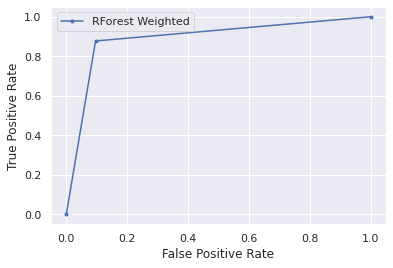

In [25]:
fpr, tpr,_ = roc_curve(ytest,ypred)
plt.plot(fpr, tpr, marker='.', label='RForest Weighted')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [26]:
fpr

array([0.        , 0.09610925, 1.        ])

In [27]:
# test performance metrics for recall metric, logistic
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     23286
           1       0.39      0.88      0.54      1615

    accuracy                           0.90     24901
   macro avg       0.69      0.89      0.74     24901
weighted avg       0.95      0.90      0.92     24901



In [264]:
# train performance metrics for recall metric logistic
ytrain_pred = gcv.predict(Xtrain)
print(classification_report(ytrain,ytrain_pred))

              precision    recall  f1-score   support

           0       0.99      0.82      0.89     93313
           1       0.24      0.88      0.38      6288

    accuracy                           0.82     99601
   macro avg       0.62      0.85      0.64     99601
weighted avg       0.94      0.82      0.86     99601



In [221]:
# test performance metrics for recall metric, logistic reg
# print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     23341
           1       0.37      0.88      0.52      1560

    accuracy                           0.90     24901
   macro avg       0.68      0.89      0.73     24901
weighted avg       0.95      0.90      0.92     24901



In [226]:
# train performance metrics for recall metric logistic
# ytrain_pred = gcv.predict(Xtrain)
# print(classification_report(ytrain,ytrain_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     93313
           1       0.44      0.95      0.60      6288

    accuracy                           0.92     99601
   macro avg       0.72      0.93      0.78     99601
weighted avg       0.96      0.92      0.93     99601



In [180]:
# test performance using auc-roc as metric for cross validation logistic
# print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     23341
           1       0.60      0.74      0.66      1560

    accuracy                           0.95     24901
   macro avg       0.79      0.85      0.82     24901
weighted avg       0.96      0.95      0.95     24901



In [181]:
# baseline on the model using auc-roc as metric for cross validation logistic
# ytrain_pred = gcv.predict(Xtrain)
# print(classification_report(ytrain,ytrain_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     93313
           1       0.62      0.77      0.69      6288

    accuracy                           0.96     99601
   macro avg       0.80      0.87      0.83     99601
weighted avg       0.96      0.96      0.96     99601



### Save Best Estimator

In [28]:
dill.dump(gcv.best_estimator_, open('./Pickled/classifierOTC.dill', 'wb'))

In [251]:
classifier = dill.load(open('./Pickled/classifierOTC.dill','rb'))

In [252]:
(classifier.predict(Xtest)==ypred).sum()

24901

In [194]:
n = 38
print(Xtest[n], ytest.values[n], gcv.predict([Xtest[n]]))

st floor - horiz. addition approx '", remodel (e) living room.  nd floor horiz. addition approx '", remodel (e) bedroom. rd floor horiz addition approx. '" plus roof deck, remodel (e) bedroom. 1 [1]


In [214]:
def test_synthetic(st):
    return gcv.predict([st])
fakepermit = 'replace window addition horiz remodel bedroom'
test_synthetic(fakepermit)

array([0])

## Extract the indices where non-zero is predicted for use in training the regressor


In [257]:
nz_array = gcv.predict(ml_ready['Description'])==1

In [258]:
nz_array

array([False, False,  True, ...,  True,  True,  True])

In [268]:
reg_ready = ml_ready.iloc[nz_array]

In [270]:
dill.dump(reg_ready, open('./Pickled/reg_ready.dill','wb'))

In [271]:
z = dill.load(open('./Pickled/reg_ready.dill', 'rb'))

In [274]:
z.head()

,Permit Number,Permit Type,Permit Type Definition,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,Number of Existing Stories,...,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,delta_stories,delta_units,approve_days,bin_class
6,201608296300,3,additions alterations or repairs,comply with nov permit for furnace/water heat...,issued,05/30/2019,2016-08-29,2019-05-30,NaN,2.0,...,180566,421328,0,3.0,3G,Ingleside Heights,0.0,1.0,1004,1
10,201610210942,3,additions alterations or repairs,unit legalization ord #-. interior alteration ...,issued,01/17/2019,2016-10-21,2019-01-17,NaN,2.0,...,171424,399997,0,10.0,10G,Silver Terrace,0.0,1.0,818,1
13,201410027943,3,additions alterations or repairs,legalization of dwelling unit installed withou...,issued,09/10/2018,2014-10-02,2018-09-10,NaN,2.0,...,106737,115393,0,10.0,10B,Croker Amazon,0.0,1.0,1439,1
17,201706270468,3,additions alterations or repairs,addition of new unit on st floor. no exterior ...,complete,09/18/2019,2017-06-27,2019-02-28,09/18/2019,3.0,...,450891,1029207,0,2.0,2F,Inner Sunset,0.0,1.0,611,1
21,201712015271,3,additions alterations or repairs,"horizontal & vertical addition, interior remod...",issued,01/16/2019,2017-12-01,2019-01-16,NaN,2.0,...,703800,1642200,0,9.0,9C,Inner Mission,1.0,2.0,411,1


## Other

In [ ]:
# spacy provides one way to tokenize words: this can be userful for smaller documents. 
doc = nlp(samples[1])

In [ ]:
doc